In [2]:
import pandas as pd
from quartic_sdk.model import BaseQuarticModel
from quartic_sdk import APIClient
import os


In [3]:
client = APIClient(
    os.environ.get("QUARTIC_HOST"),
    username=os.environ.get("QUARTIC_USERNAME"),
    password=os.environ.get("QUARTIC_PASSWORD"),
    verify_ssl=False,
)

assets = client.assets()
asset = assets.get("id", 258)


In [6]:
asset_data_itr = asset.data(start_time=1620650445000, stop_time=1620654045000)
df = pd.DataFrame()
for next_df in asset_data_itr:
    df = pd.concat([df, next_df])

target_col = "32256"
feature_cols = ["32257", "32255"]


In [10]:
# Data Characteristics
print("Shape : ", df.shape)
print("\n", df[feature_cols].describe())

Shape :  (7135, 3)

              32257        32255
count  7082.000000  6833.000000
mean     15.017227    15.028977
std       8.940544     8.937071
min       0.000000     0.000000
25%       7.000000     7.000000
50%      15.000000    15.000000
75%      23.000000    23.000000
max      30.000000    30.000000


In [11]:
df = df.dropna(axis=0)

In [12]:
df_X = df[feature_cols]
df_y = df[[target_col]]
X = df_X.to_numpy()
y = df_y.to_numpy()
y = y.reshape(-1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

e:\tp\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Root Mean Squared Error :  0.0
Mean Absolute Error :  0.0


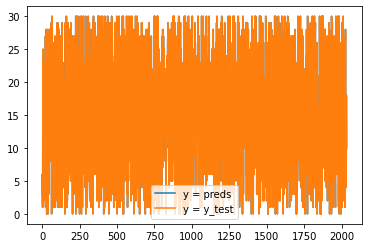

In [13]:
# apply processed data to a Random Forest Regressor model
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

reg = RandomForestRegressor().fit(X_train, y_train)
preds = reg.predict(X_test)

plt.plot(preds)
plt.plot(y_test)
plt.legend(["y = preds", "y = y_test"])

print("Root Mean Squared Error : ", math.sqrt(mean_squared_error(y_test, preds)))
print("Mean Absolute Error : ", mean_squared_error(y_test, preds))


In [14]:
from quartic_sdk.model import BaseQuarticModel


class RandomForestRegressionModel(BaseQuarticModel):
    def __init__(self, name, description, model):
        self.model = model
        super().__init__(name=name, description=description)

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_predict):
        predictions = self.model.predict(X_predict)
        return pd.Series(predictions)


RF_regressor_model = RandomForestRegressionModel(
    name="Random_Forest_Regressor",
    description="Simple model using Random Forest Regression",
    model=reg,
)

RF_regressor_model.train(
    X_train, y_train
)  # Training data extracted from data loaded from the Quartic AI Platform

RF_regressor_model.predict(df_X)

RF_regressor_model.save(
    client=client,
    output_tag_name=f"Prediction Result of {target_col}",
    feature_tags=feature_cols,  # tags that are used in the X variable or features
    target_tag=target_col,  # tag that specifies a relationship for prediction
    test_df=df_X,
)
